In [1]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pymc3 import __version__
import seaborn as sns
plt.style.use('seaborn-darkgrid')
print('Running on PyMC3 v{}'. format(__version__))

from pymc3 import get_data

Running on PyMC3 v3.6


In [16]:
import os
os.chdir('/home/qc/modelling_projects')

In [52]:
srrs2 = pd.read_csv('srrs2.dat')
srrs2.columns = srrs2.columns.map(str.strip)
srrs_mn = srrs2[srrs2.state == 'MN'].copy()
srrs_mn['fips'] = srrs_mn.stfips * 1000 + srrs_mn.cntyfips

In [53]:
cty = pd.read_csv('cty.dat')

In [54]:
cty_mn = cty[cty.st == 'MN'].copy()
cty_mn['fips'] = 1000 * cty_mn.stfips + cty_mn.ctfips

In [55]:
srrs_mn = srrs_mn.merge(cty_mn[['fips', 'Uppm']], on = 'fips')
srrs_mn = srrs_mn.drop_duplicates(subset = 'idnum')
u = np.log(srrs_mn.Uppm)

n = len(srrs_mn)

In [57]:
srrs_mn.head()

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,...,stopdt,activity,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips,Uppm
0,5081,MN,MN,27,55735,5,1,1,3,N,...,12288,2.2,9.7,1146.499190,1,0,1,AITKIN,27001,0.502054
1,5082,MN,MN,27,55748,5,1,0,4,Y,...,12088,2.2,14.5,471.366223,0,0,1,AITKIN,27001,0.502054
2,5083,MN,MN,27,55748,5,1,0,4,Y,...,21188,2.9,9.6,433.316718,0,0,1,AITKIN,27001,0.502054
3,5084,MN,MN,27,56469,5,1,0,4,Y,...,123187,1.0,24.3,461.623670,0,0,1,AITKIN,27001,0.502054
4,5085,MN,MN,27,55011,3,1,0,4,Y,...,13088,3.1,13.8,433.316718,0,0,3,ANOKA,27003,0.428565


In [58]:
srrs_mn.county = srrs_mn.county.map(str.strip)
mn_counties = srrs_mn.county.unique()
counties = len(mn_counties)
county_lookup = dict(zip(mn_counties, range(len(mn_counties))))

In [63]:
county = srrs_mn['county_code'] = srrs_mn.county.replace(county_lookup).values

radon = srrs_mn.activity
srrs_mn['log_radon'] = log_radon = np.log(radon + 0.1).values
floor_measure = srrs_mn.floor.values

Distribution of radon levels in MN (log scale):

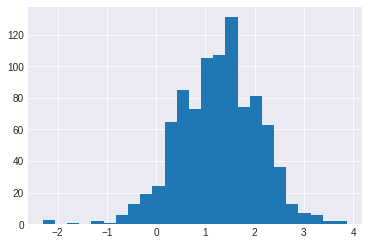

In [65]:
srrs_mn.activity.apply(lambda x: np.log(x + 0.1)).hist(bins = 25)

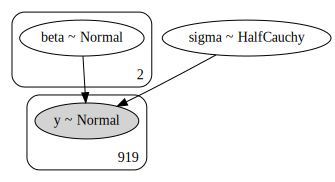

In [75]:
from pymc3 import Model, sample, Normal, HalfCauchy, Uniform, model_to_graphviz

floor = srrs_mn.floor.values
log_radon = srrs_mn.log_radon.values

with Model() as pooled_model:

    beta = Normal('beta', 0, sd=1e5, shape=2)
    sigma = HalfCauchy('sigma', 5)

    theta = beta[0] + beta[1]*floor

    y = Normal('y', theta, sd=sigma, observed=log_radon)
model_to_graphviz(pooled_model)

In [77]:
with pooled_model:
    pooled_trace = sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1259.10draws/s]


In [78]:
b0, m0 = pooled_trace['beta'].mean(axis=0)

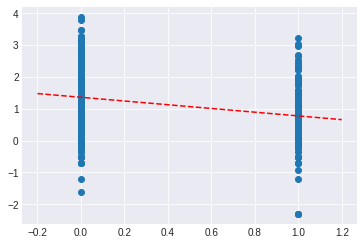

In [79]:
plt.scatter(srrs_mn.floor, np.log(srrs_mn.activity+0.1))
xvals = np.linspace(-0.2, 1.2)
plt.plot(xvals, m0*xvals+b0, 'r--');

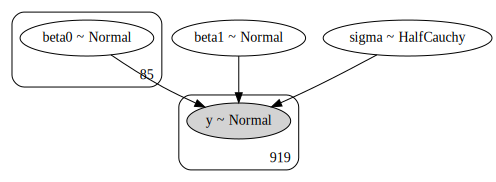

In [80]:
with Model() as unpooled_model:

    beta0 = Normal('beta0', 0, sd=1e5, shape=counties)
    beta1 = Normal('beta1', 0, sd=1e5)
    sigma = HalfCauchy('sigma', 5)

    theta = beta0[county] + beta1*floor

    y = Normal('y', theta, sd=sigma, observed=log_radon)
model_to_graphviz(unpooled_model)

In [82]:
with unpooled_model:
    unpooled_trace = sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta1, beta0]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:09<00:00, 436.62draws/s]


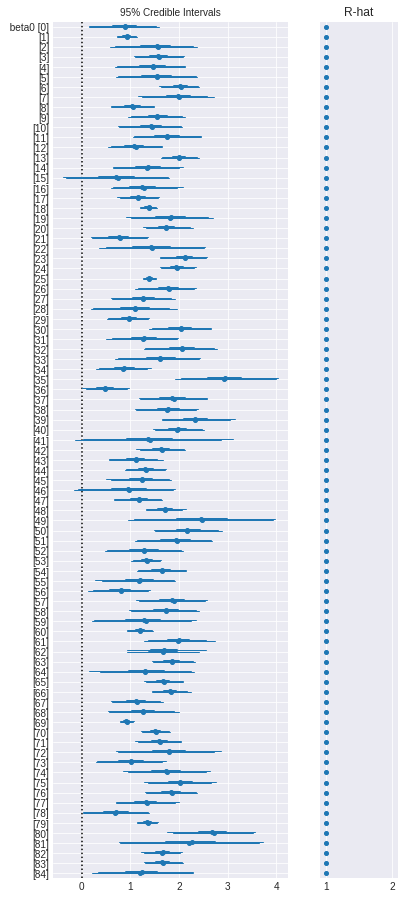

In [84]:
from pymc3 import forestplot

plt.figure(figsize=(6,14))
forestplot(unpooled_trace, varnames=['beta0']);

In [85]:
unpooled_estimates = pd.Series(unpooled_trace['beta0'].mean(axis=0), index=mn_counties)
unpooled_se = pd.Series(unpooled_trace['beta0'].std(axis=0), index=mn_counties)

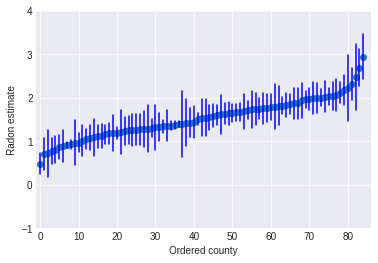

In [86]:
order = unpooled_estimates.sort_values().index

plt.scatter(range(len(unpooled_estimates)), unpooled_estimates[order])
for i, m, se in zip(range(len(unpooled_estimates)), unpooled_estimates[order], unpooled_se[order]):
    plt.plot([i,i], [m-se, m+se], 'b-')
plt.xlim(-1,86); plt.ylim(-1,4)
plt.ylabel('Radon estimate');plt.xlabel('Ordered county');

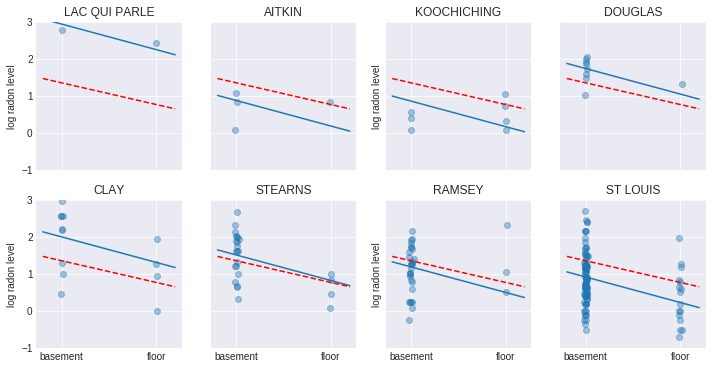

In [87]:
sample_counties = ('LAC QUI PARLE', 'AITKIN', 'KOOCHICHING',
                    'DOUGLAS', 'CLAY', 'STEARNS', 'RAMSEY', 'ST LOUIS')

fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()
m = unpooled_trace['beta1'].mean()
for i,c in enumerate(sample_counties):
    y = srrs_mn.log_radon[srrs_mn.county==c]
    x = srrs_mn.floor[srrs_mn.county==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)

    # No pooling model
    b = unpooled_estimates[c]

    # Plot both models and data
    xvals = np.linspace(-0.2, 1.2)
    axes[i].plot(xvals, m*xvals+b)
    axes[i].plot(xvals, m0*xvals+b0, 'r--')
    axes[i].set_xticks([0,1])
    axes[i].set_xticklabels(['basement', 'floor'])
    axes[i].set_ylim(-1, 3)
    axes[i].set_title(c)
    if not i%2:
        axes[i].set_ylabel('log radon level')

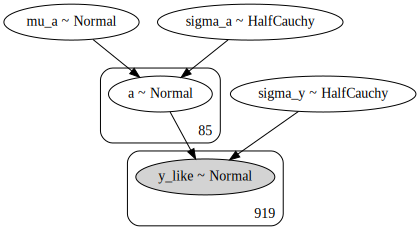

In [88]:
with Model() as partial_pooling:

    # Priors
    mu_a = Normal('mu_a', mu=0., sd=1e5)
    sigma_a = HalfCauchy('sigma_a', 5)

    # Random intercepts
    a = Normal('a', mu=mu_a, sd=sigma_a, shape=counties)

    # Model error
    sigma_y = HalfCauchy('sigma_y',5)

    # Expected value
    y_hat = a[county]

    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sd=sigma_y, observed=log_radon)

model_to_graphviz(partial_pooling)

In [89]:
with partial_pooling:
    partial_pooling_trace = sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_y, a, sigma_a, mu_a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:08<00:00, 490.62draws/s]
The number of effective samples is smaller than 25% for some parameters.


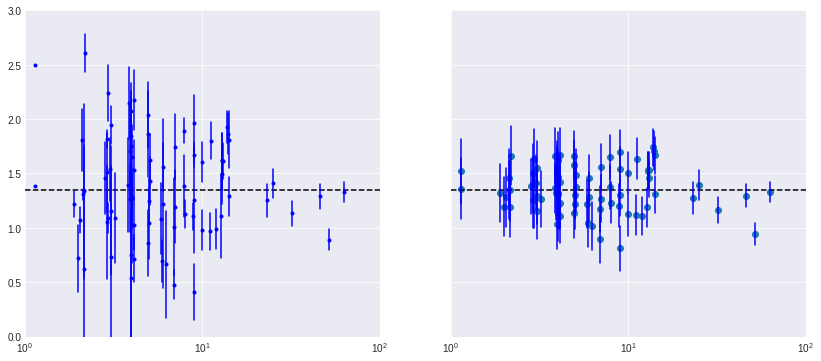

In [90]:
sample_trace = partial_pooling_trace['a']

fig, axes = plt.subplots(1, 2, figsize=(14,6), sharex=True, sharey=True)
samples, counties = sample_trace.shape
jitter = np.random.normal(scale=0.1, size=counties)

n_county = srrs_mn.groupby('county')['idnum'].count()
unpooled_means = srrs_mn.groupby('county')['log_radon'].mean()
unpooled_sd = srrs_mn.groupby('county')['log_radon'].std()
unpooled = pd.DataFrame({'n':n_county, 'm':unpooled_means, 'sd':unpooled_sd})
unpooled['se'] = unpooled.sd/np.sqrt(unpooled.n)

axes[0].plot(unpooled.n + jitter, unpooled.m, 'b.')
for j, row in zip(jitter, unpooled.iterrows()):
    name, dat = row
    axes[0].plot([dat.n+j,dat.n+j], [dat.m-dat.se, dat.m+dat.se], 'b-')
axes[0].set_xscale('log')
axes[0].hlines(sample_trace.mean(), 0.9, 100, linestyles='--')


samples, counties = sample_trace.shape
means = sample_trace.mean(axis=0)
sd = sample_trace.std(axis=0)
axes[1].scatter(n_county.values + jitter, means)
axes[1].set_xscale('log')
axes[1].set_xlim(1,100)
axes[1].set_ylim(0, 3)
axes[1].hlines(sample_trace.mean(), 0.9, 100, linestyles='--')
for j,n,m,s in zip(jitter, n_county.values, means, sd):
    axes[1].plot([n+j]*2, [m-s, m+s], 'b-')

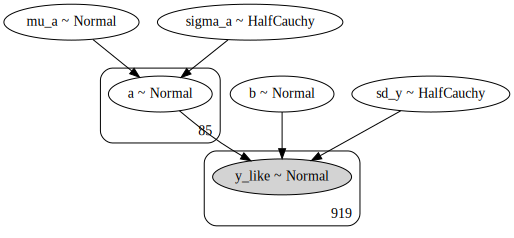

In [91]:
with Model() as varying_intercept:

    # Priors
    mu_a = Normal('mu_a', mu=0., tau=0.0001)
    sigma_a = HalfCauchy('sigma_a', 5)


    # Random intercepts
    a = Normal('a', mu=mu_a, sd=sigma_a, shape=counties)
    # Common slope
    b = Normal('b', mu=0., sd=1e5)

    # Model error
    sd_y = HalfCauchy('sd_y', 5)

    # Expected value
    y_hat = a[county] + b * floor_measure

    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sd=sd_y, observed=log_radon)

model_to_graphviz(varying_intercept)

In [92]:
with varying_intercept:
    varying_intercept_trace = sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd_y, b, a, sigma_a, mu_a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:08<00:00, 484.85draws/s]


GridSpec(1, 2, width_ratios=[3, 1])

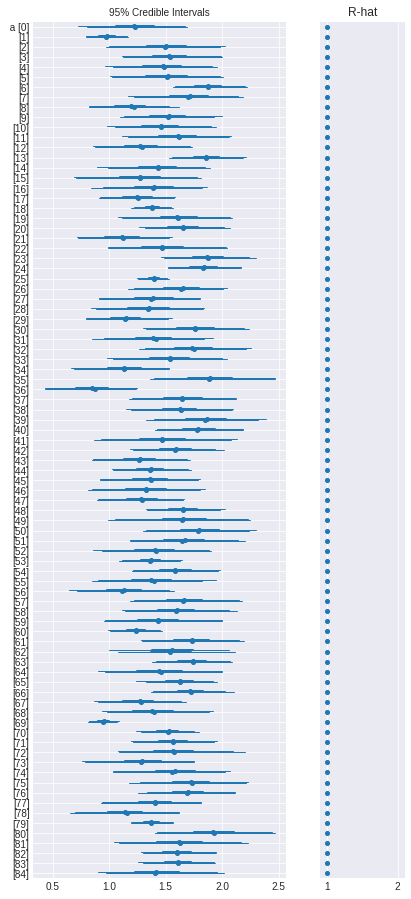

In [93]:
from pymc3 import forestplot, traceplot, plot_posterior

plt.figure(figsize=(6,14))
forestplot(varying_intercept_trace, varnames=['a'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1664bd9550>,
      dtype=object)

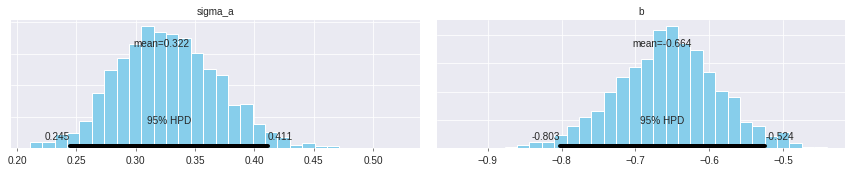

In [94]:
plot_posterior(varying_intercept_trace, varnames=['sigma_a', 'b'])

In [95]:
from pymc3 import summary

summary(varying_intercept_trace, varnames=['b'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
b,-0.66448,0.069461,0.001851,-0.802602,-0.524246,1317.361768,1.000759


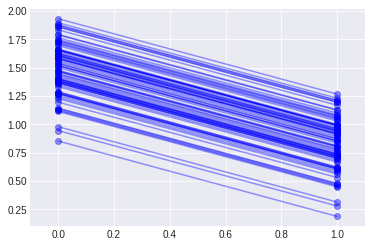

In [96]:
xvals = np.arange(2)
bp = varying_intercept_trace[a].mean(axis=0)
mp = varying_intercept_trace[b].mean()
for bi in bp:
    plt.plot(xvals, mp*xvals + bi, 'bo-', alpha=0.4)
plt.xlim(-0.1,1.1);

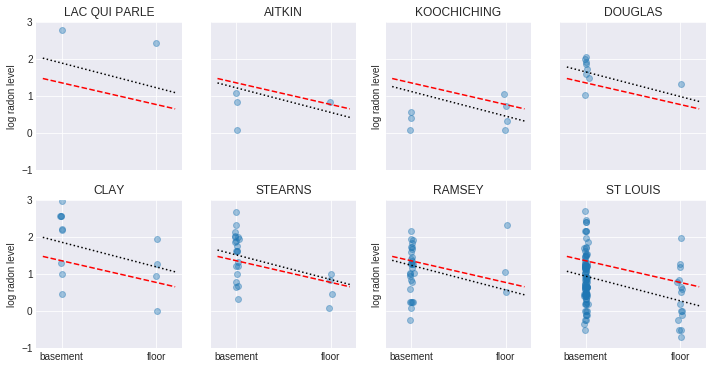

In [99]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()
for i,c in enumerate(sample_counties):

    # Plot county data
    y = srrs_mn.log_radon[srrs_mn.county==c]
    x = srrs_mn.floor[srrs_mn.county==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)

    # No pooling model
    m,b = unpooled_estimates[['floor', c]]

    xvals = np.linspace(-0.2, 1.2)
    # Unpooled estimate
    axes[i].plot(xvals, m*xvals+b)
    # Pooled estimate
    axes[i].plot(xvals, m0*xvals+b0, 'r--')
    # Partial pooling esimate
    axes[i].plot(xvals, mp*xvals+bp[county_lookup[c]], 'k:')
    axes[i].set_xticks([0,1])
    axes[i].set_xticklabels(['basement', 'floor'])
    axes[i].set_ylim(-1, 3)
    axes[i].set_title(c)
    if not i%2:
        axes[i].set_ylabel('log radon level')

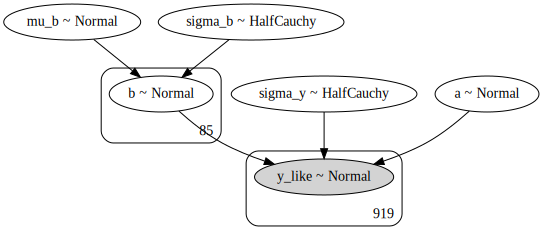

In [100]:
with Model() as varying_slope:

    # Priors
    mu_b = Normal('mu_b', mu=0., sd=1e5)
    sigma_b = HalfCauchy('sigma_b', 5)

    # Common intercepts
    a = Normal('a', mu=0., sd=1e5)
    # Random slopes
    b = Normal('b', mu=mu_b, sd=sigma_b, shape=counties)

    # Model error
    sigma_y = HalfCauchy('sigma_y',5)

    # Expected value
    y_hat = a + b[county] * floor_measure

    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sd=sigma_y, observed=log_radon)

model_to_graphviz(varying_slope)

In [101]:
with varying_slope:
    varying_slope_trace = sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_y, b, a, sigma_b, mu_b]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:11<00:00, 337.25draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


GridSpec(1, 2, width_ratios=[3, 1])

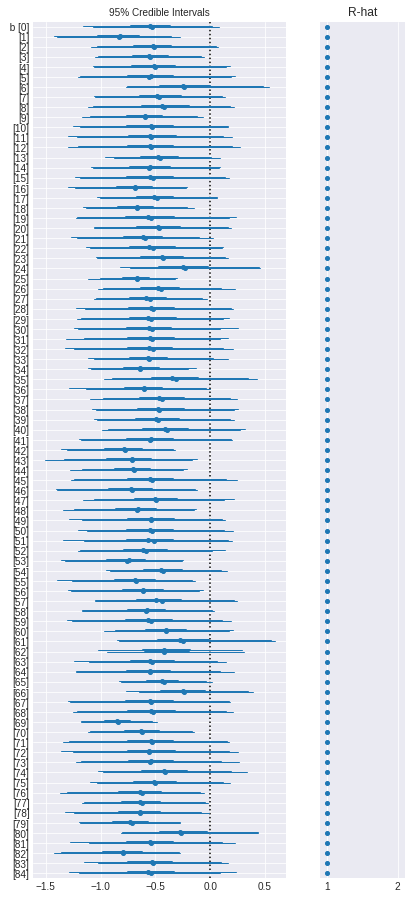

In [102]:
plt.figure(figsize=(6,14))
forestplot(varying_slope_trace, varnames=['b'])

(-0.2, 1.2)

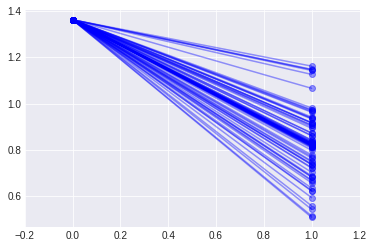

In [103]:
xvals = np.arange(2)
b = varying_slope_trace['a'].mean()
m = varying_slope_trace['b'].mean(axis=0)
for mi in m:
    plt.plot(xvals, mi*xvals + b, 'bo-', alpha=0.4)
plt.xlim(-0.2, 1.2)

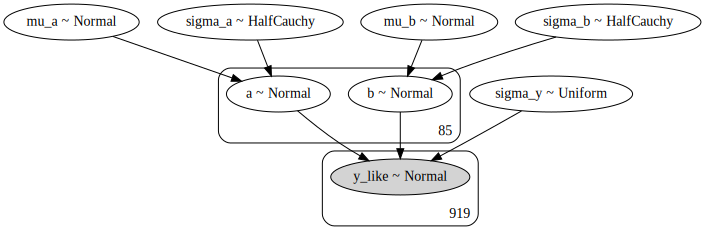

In [104]:
with Model() as varying_intercept_slope:

    # Priors
    mu_a = Normal('mu_a', mu=0., sd=1e5)
    sigma_a = HalfCauchy('sigma_a', 5)
    mu_b = Normal('mu_b', mu=0., sd=1e5)
    sigma_b = HalfCauchy('sigma_b', 5)

    # Random intercepts
    a = Normal('a', mu=mu_a, sd=sigma_a, shape=counties)
    # Random slopes
    b = Normal('b', mu=mu_b, sd=sigma_b, shape=counties)

    # Model error
    sigma_y = Uniform('sigma_y', lower=0, upper=100)

    # Expected value
    y_hat = a[county] + b[county] * floor_measure

    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sd=sigma_y, observed=log_radon)

model_to_graphviz(varying_intercept_slope)

In [105]:
with varying_intercept_slope:
    varying_intercept_slope_trace = sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_y, b, a, sigma_b, mu_b, sigma_a, mu_a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:18<00:00, 217.19draws/s]
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6606180918207876, but should be close to 0.8. Try to increase the number of tuning steps.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.011850594000484055, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


GridSpec(1, 2, width_ratios=[3, 1])

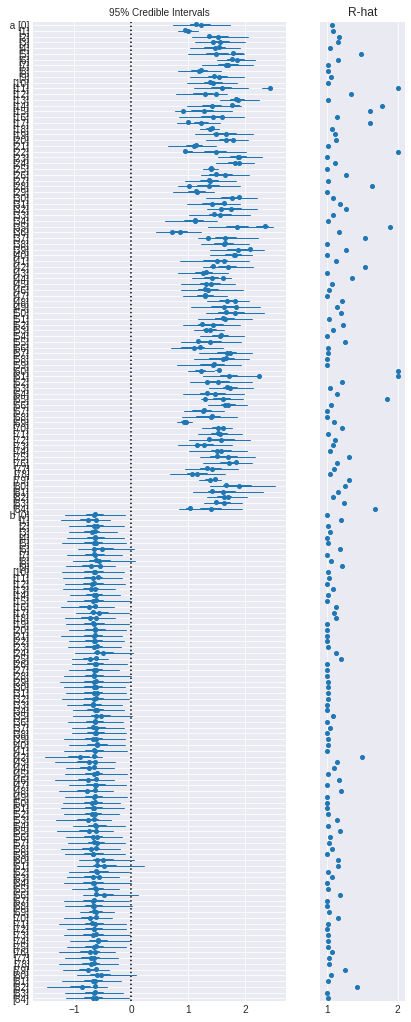

In [106]:
plt.figure(figsize=(6,16))
forestplot(varying_intercept_slope_trace, varnames=['a','b'])

(-0.1, 1.1)

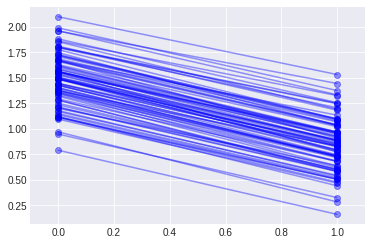

In [107]:
xvals = np.arange(2)
b = varying_intercept_slope_trace['a'].mean(axis=0)
m = varying_intercept_slope_trace['b'].mean(axis=0)
for bi,mi in zip(b,m):
    plt.plot(xvals, mi*xvals + bi, 'bo-', alpha=0.4)
plt.xlim(-0.1, 1.1)

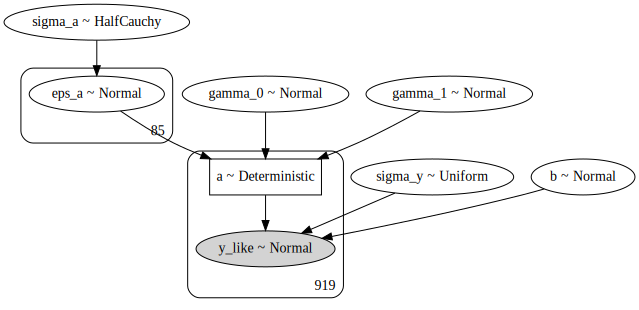

In [108]:
from pymc3 import Deterministic

with Model() as hierarchical_intercept:

    # Priors
    sigma_a = HalfCauchy('sigma_a', 5)

    # County uranium model for slope
    gamma_0 = Normal('gamma_0', mu=0., sd=1e5)
    gamma_1 = Normal('gamma_1', mu=0., sd=1e5)


    # Uranium model for intercept
    mu_a = gamma_0 + gamma_1*u
    # County variation not explained by uranium
    eps_a = Normal('eps_a', mu=0, sd=sigma_a, shape=counties)
    a = Deterministic('a', mu_a + eps_a[county])

    # Common slope
    b = Normal('b', mu=0., sd=1e5)

    # Model error
    sigma_y = Uniform('sigma_y', lower=0, upper=100)

    # Expected value
    y_hat = a + b * floor_measure

    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sd=sigma_y, observed=log_radon)

model_to_graphviz(hierarchical_intercept)

In [109]:
with hierarchical_intercept:
    hierarchical_intercept_trace = sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_y, b, eps_a, gamma_1, gamma_0, sigma_a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:15<00:00, 261.58draws/s]
There were 236 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.47631501407733284, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


Text(0, 0.5, 'Intercept estimate')

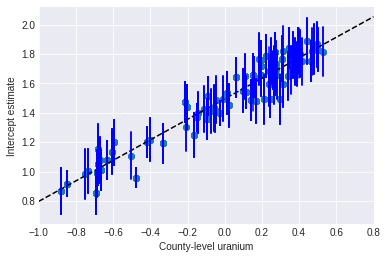

In [110]:
a_means = hierarchical_intercept_trace['a'].mean(axis=0)
plt.scatter(u, a_means)
g0 = hierarchical_intercept_trace['gamma_0'].mean()
g1 = hierarchical_intercept_trace['gamma_1'].mean()
xvals = np.linspace(-1, 0.8)
plt.plot(xvals, g0+g1*xvals, 'k--')
plt.xlim(-1, 0.8)

a_se = hierarchical_intercept_trace['a'].std(axis=0)
for ui, m, se in zip(u, a_means, a_se):
    plt.plot([ui,ui], [m-se, m+se], 'b-')
plt.xlabel('County-level uranium'); plt.ylabel('Intercept estimate')

In [111]:
# Create new variable for mean of floor across counties
xbar = srrs_mn.groupby('county')['floor'].mean().rename(county_lookup).values

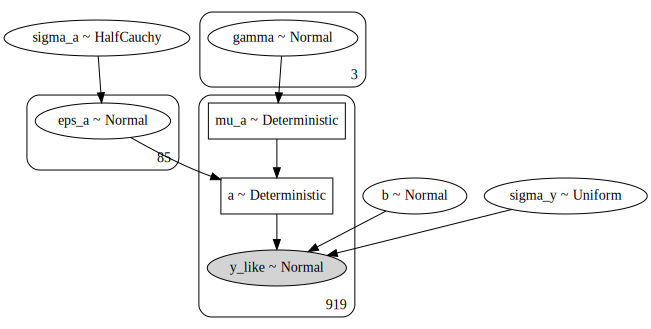

In [112]:
with Model() as contextual_effect:

    # Priors
    sigma_a = HalfCauchy('sigma_a', 5)

    # County uranium model for slope
    gamma = Normal('gamma', mu=0., sd=1e5, shape=3)

    # Uranium model for intercept
    mu_a = Deterministic('mu_a', gamma[0] + gamma[1]*u.values + gamma[2]*xbar[county])

    # County variation not explained by uranium
    eps_a = Normal('eps_a', mu=0, sd=sigma_a, shape=counties)
    a = Deterministic('a', mu_a + eps_a[county])

    # Common slope
    b = Normal('b', mu=0., sd=1e15)

    # Model error
    sigma_y = Uniform('sigma_y', lower=0, upper=100)

    # Expected value
    y_hat = a + b * floor_measure

    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sd=sigma_y, observed=log_radon)

model_to_graphviz(contextual_effect)

In [113]:
with contextual_effect:
    contextual_effect_trace = sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_y, b, eps_a, gamma, sigma_a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:17<00:00, 226.77draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


In [114]:
summary(contextual_effect_trace, varnames=['gamma'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
gamma__0,1.428421,0.048759,0.001549,1.335605,1.523484,992.563288,0.999835
gamma__1,0.698629,0.087541,0.002485,0.528116,0.861509,1219.675869,1.001872
gamma__2,0.393045,0.191112,0.005074,0.027274,0.766103,1256.323058,0.999568


In [115]:
county_lookup['ST LOUIS']

69

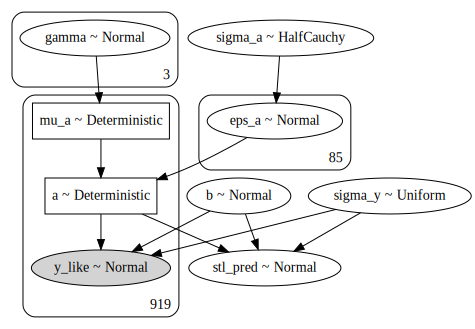

In [116]:
with Model() as contextual_pred:

    # Priors
    sigma_a = HalfCauchy('sigma_a', 5)

    # County uranium model for slope
    gamma = Normal('gamma', mu=0., sd=1e5, shape=3)

    # Uranium model for intercept
    mu_a = Deterministic('mu_a', gamma[0] + gamma[1]*u.values + gamma[2]*xbar[county])

    # County variation not explained by uranium
    eps_a = Normal('eps_a', mu=0, sd=sigma_a, shape=counties)
    a = Deterministic('a', mu_a + eps_a[county])

    # Common slope
    b = Normal('b', mu=0., sd=1e15)

    # Model error
    sigma_y = Uniform('sigma_y', lower=0, upper=100)

    # Expected value
    y_hat = a + b * floor_measure

    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sd=sigma_y, observed=log_radon)

    # St Louis county prediction
    stl_pred = Normal('stl_pred', mu=a[69] + b, sd=sigma_y)

model_to_graphviz(contextual_pred)

In [117]:
with contextual_pred:
    contextual_pred_trace = sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [stl_pred, sigma_y, b, eps_a, gamma, sigma_a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:19<00:00, 201.45draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7036202798725156, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


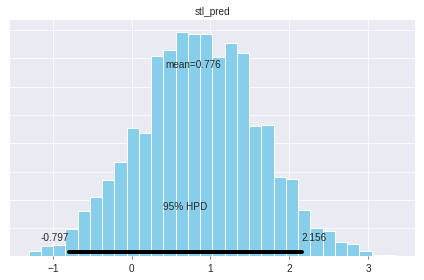

In [118]:
plot_posterior(contextual_pred_trace, varnames=['stl_pred']);